# 1 Imports

In [1]:
# imports

import os
import re
import json
import math
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from openai import OpenAI

In [2]:
# Call it with Tester.test(function_name, *args)

from testing import Tester

# 2 Connect to OpenAI & HuggingFace

In [3]:
# Load environment variables in a file called .env

load_dotenv()
api_key = os.getenv('OPEN_API_KEY')
openai = OpenAI()

In [4]:
# Load environment variables in a file called .env

load_dotenv()
hf_token = os.getenv('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# 3 Load Dataset

In [5]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# 4 Frontier Model - GPT-4o-mini

## 4.1 Prompt Preparation

In [6]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train out own models, we'll need to make the problem as easy as possible,
# But a Frontier moodel needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation."
    user_message = item.test_prompt().replace(" to the nearest dollar", "").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message},
        {"role": "assistant", "content": "Price is $"}
    ]

In [7]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation.'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nVic Firth Elementary Education Pack (includes SD1, M5, M14, BSB)\nDesigned to include the correct tools for producing quality sound at the student level, the Vic Firth Education Packs were developed with a step up approach. As the student advances from beginner to intermediate, he or she will acquire the essentials for band and orchestra literature. The EP1 contains a Vic Firth stick bag equipped with a pair of SD1 General Drumsticks, M5 Medium Hard Rubber Mallets, and M14 Poly Head Mallets. Brand Vic Firth Product Code EP1 The EP1 contains a Vic Firth stick bag equipped with a pair of SD1 General Drumsticks, M5 Medium Hard Rubber Mallets, and M14 Poly Head Mallets Weight 1 pounds,'},
 {'role': 'assistant', 'content': 'Price is $'}]

In [8]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$', '').replace(',', '')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group(0)) if match else 0

In [9]:
get_price("Price is $123.45")

123.45

## 4.2 Call GPT

In [10]:
def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $99.99 Truth: $59.99 Error: $40.00 SLE: 0.25 Item: Vic Firth Elementary Education Pack (inc...
2: Guess: $99.99 Truth: $88.73 Error: $11.26 SLE: 0.01 Item: Samson Q6 Dynamic Microphone 3-Pack, Bla...
3: Guess: $25.99 Truth: $26.59 Error: $0.60 SLE: 0.00 Item: Buckle-Down Guitar Strap Unicorn Univers...
4: Guess: $120.00 Truth: $113.40 Error: $6.60 SLE: 0.00 Item: Kluson Revolution Tuners 3x3 No Collar L...
5: Guess: $25.00 Truth: $60.99 Error: $35.99 SLE: 0.75 Item: EBXYA 1/4 TRS to XLR Male 6.5ft 6 Color ...
6: Guess: $49.99 Truth: $19.99 Error: $30.00 SLE: 0.79 Item: Tesi IDO Super M 10mm Stainless Steel Ki...
7: Guess: $29.99 Truth: $21.23 Error: $8.76 SLE: 0.11 Item: ICEPURE 5231JA2002A Refrigerator Water F...
8: Guess: $10.99 Truth: $5.99 Error: $5.00 SLE: 0.29 Item: Kmise Round Head Strap Locks Straplocks ...
9: Guess: $23.00 Truth: $3.99 Error: $19.01 SLE: 2.47 Item: FUPEI 9 Pcs Maple Syrup 1 Quart Filter S...
10: Guess: $99.99 Truth: $80.00 Error: $19.99 SLE: 0.05 Ite

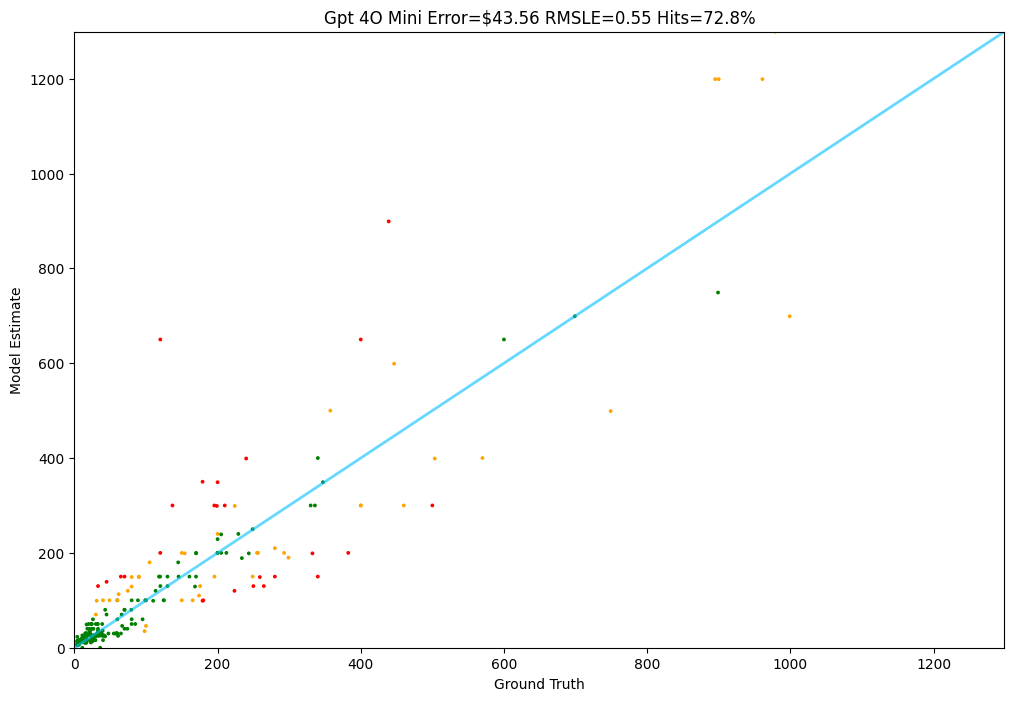

In [11]:
Tester.test(gpt_4o_mini,test)

# 5 Frontier Model - GPT-4o

In [12]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $54.99 Truth: $59.99 Error: $5.00 SLE: 0.01 Item: Vic Firth Elementary Education Pack (inc...
2: Guess: $99.99 Truth: $88.73 Error: $11.26 SLE: 0.01 Item: Samson Q6 Dynamic Microphone 3-Pack, Bla...
3: Guess: $25.00 Truth: $26.59 Error: $1.59 SLE: 0.00 Item: Buckle-Down Guitar Strap Unicorn Univers...
4: Guess: $66.95 Truth: $113.40 Error: $46.45 SLE: 0.27 Item: Kluson Revolution Tuners 3x3 No Collar L...
5: Guess: $32.99 Truth: $60.99 Error: $28.00 SLE: 0.36 Item: EBXYA 1/4 TRS to XLR Male 6.5ft 6 Color ...
6: Guess: $15.99 Truth: $19.99 Error: $4.00 SLE: 0.04 Item: Tesi IDO Super M 10mm Stainless Steel Ki...
7: Guess: $21.99 Truth: $21.23 Error: $0.76 SLE: 0.00 Item: ICEPURE 5231JA2002A Refrigerator Water F...
8: Guess: $5.00 Truth: $5.99 Error: $0.99 SLE: 0.02 Item: Kmise Round Head Strap Locks Straplocks ...
9: Guess: $32.99 Truth: $3.99 Error: $29.00 SLE: 3.68 Item: FUPEI 9 Pcs Maple Syrup 1 Quart Filter S...
10: Guess: $99.99 Truth: $80.00 Error: $19.99 SLE: 0.05 Item: 

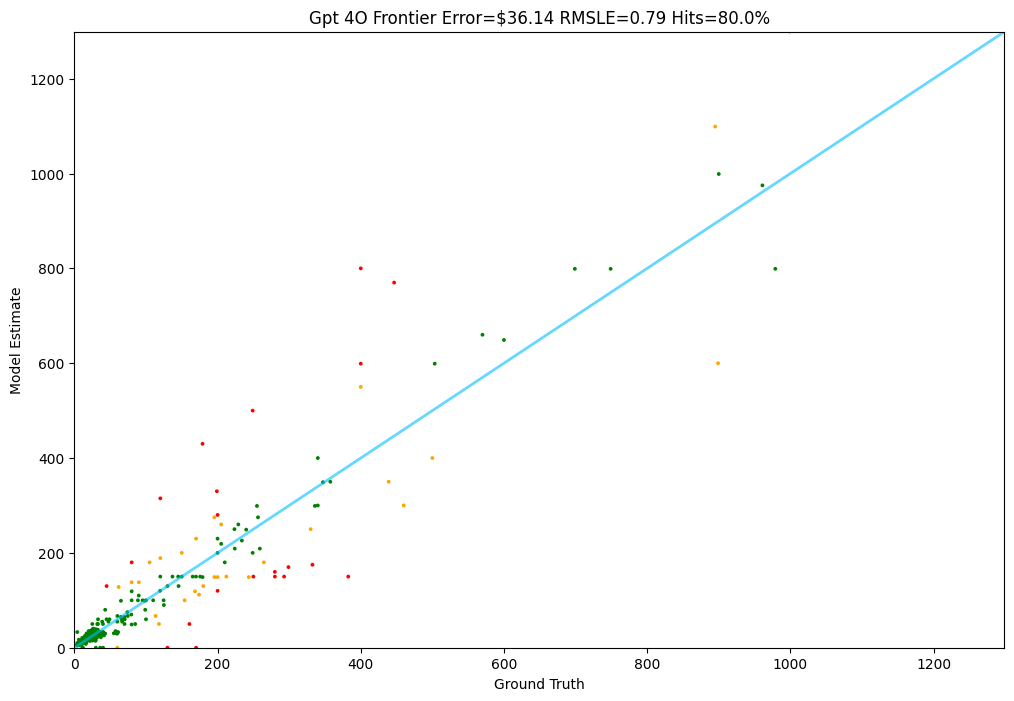

In [13]:
Tester.test(gpt_4o_frontier,test)